# Object Finder
Here, we'll explore finding objects in spectrographs produced from the LTO 21-cm data. The objective is to produce a list of objects from an input spectrograph. For each object, provide its bounding box, its object type and possibly some descriptive statistics.

## Get the Spectrograph
The SpectroGraph class loads up data from a specified directory as its `__init__` method.

In [1]:
# load up necessary libraries
import numpy as np
import pandas as pd
from LTO_Utils import *
from os import listdir
from os.path import isfile, join
import re
from SpectroGraph import *


In [2]:
# instantiate the spectrograph
sprg = SpectroGraph('data', dFclip=(-700,700))

## Plot the original

In [3]:
# plot libraries and plot defaults

import matplotlib.pyplot as plt
from matplotlib import rcParams, cm
import matplotlib.colors as colors

%matplotlib inline
rcParams['figure.figsize'] = [10.0, 10.0]
rcParams['font.size'] = 14
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

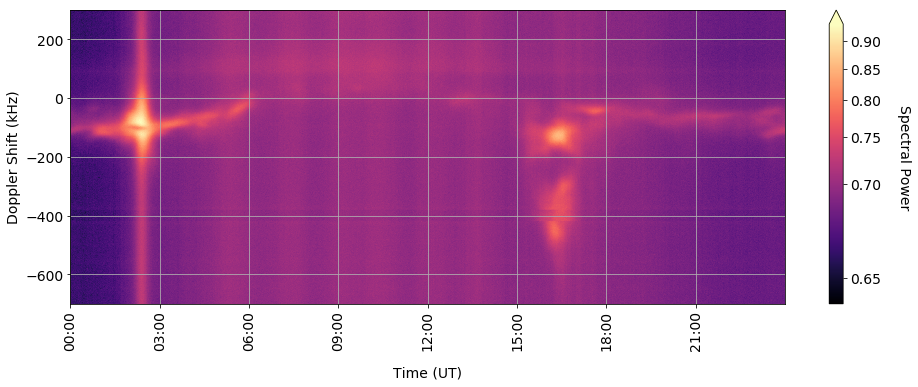

In [4]:
#make a time x frequency grid(mesh) for automatic axis labeling
Xtimes, Yfreqs = np.meshgrid(sprg.times, sprg.freqs)

fmt = mdates.DateFormatter('%H:%M') #formatter to show just the hours and minutes on the x-axis

fig, ax = plt.subplots(figsize=(16,6))

#color mesh plot
pcm = ax.pcolormesh(Xtimes, Yfreqs, sprg.pwr,
                   #norm=colors.LogNorm(vmin=pwr.min(), vmax=pwr.max()), #uncomment for log normalized
                    norm=colors.PowerNorm(gamma=1./2.),
                    cmap='magma')

#reformat the x-axis tick labels only to show hh:mm
ax.set_xticklabels([fmt(t) for t in ax.get_xticks() ], rotation=90)
ax.set_xlabel('Time (UT)', labelpad=15)
ax.set_ylabel('Doppler Shift (kHz)')
ax.set_ylim(-700,300) #to match the picture
ax.grid()
fig.subplots_adjust(bottom=0.2) # to make room for x-axis tick labels

#tack on and label the color bar on the right
cbar=fig.colorbar(pcm, ax=ax, extend='max')
cbar.set_label('Spectral Power', rotation=270, labelpad=30)


## Object Finding and Labeling
The Python library `skimage` provides an extensive toolset for image processing. The `label` function will take a boolean array and group adjacent 'true' values into features and mark each pixel with a value (0..n_features) indicating to which feature the pixel belongs. The return value frmo `label` has the same shape as the input image.

Having labeled the pixels in the image, the function `regionprops` produces descriptive information about each feature in the input image. `regionprops` can compute the centroid of the feature, its maximum intensity, the coordinates of all of the pixels in the feature and much more. See [documentation](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) for a list of available properties

In [5]:
# more libraries
from skimage import measure
from skimage.measure import label, regionprops
import pandas as pd

Previously, we established that power values >= 0.75 represent potential HI emission regions. So we'll find and label adjacent pixels whose power values exceed that threshold.
The maximum value in the returned labeled image in the number of features identified.

In [6]:
# find and label features whose power values are at least 0.75
label_image = label(sprg.pwr >= 0.75)
label_image.max()

91

So 91 features identified.

Get the `regionprops` of these 91 regions or features. For each feature, arbitrarily get its feature identifier, weighted centroid, area, mean and max intensities. Put these in a data frame for easy consumption later.

Note many of the features identified are quite small in area, so we'll ignore any feature whose area is less than 100 pixels.

In [7]:
#get the props
regprops = regionprops(label_image, sprg.pwr)

#make data frame, one row for each feature, columns for measures of interest
props =pd.DataFrame([[rp.label, rp.weighted_centroid, rp.area, rp.mean_intensity, rp.max_intensity] for rp in regprops if rp.area >= 100],
                    columns = ['FeatureId', 'WeightedCentroid','Area', 'MeanPower','MaxPower'])


In [8]:
props

,FeatureId,WeightedCentroid,Area,MeanPower,MaxPower
0,3,"(517.356966383, 967.69780298)",7932,0.759805,0.786659
1,28,"(1004.22546551, 148.282920683)",24223,0.799427,0.934163
2,33,"(941.124373217, 969.184765887)",7954,0.787234,0.859703
3,69,"(1089.5909084, 332.486655437)",1247,0.758213,0.771017
4,70,"(1079.29860984, 1039.35706653)",969,0.761048,0.779452


Five features with an area of at lease one hundred pixels.

## Plot the Features
The code below recreates the original plot and then superimposes the five features.  The rectangles are the features' bounding boxes, the blobs are the pixels that comprise the features.  Note that the bounding boxes enclose pixels that are not part of the feature; the bounding box edges are determined by the feature's extent in the x- (time) and y- (time) dimensions. Later in the notebook, we'll show two ways to extract only the pixels that comprise a particular feature

Note that we lost axis labeling in the process; we'll get it back in the future.

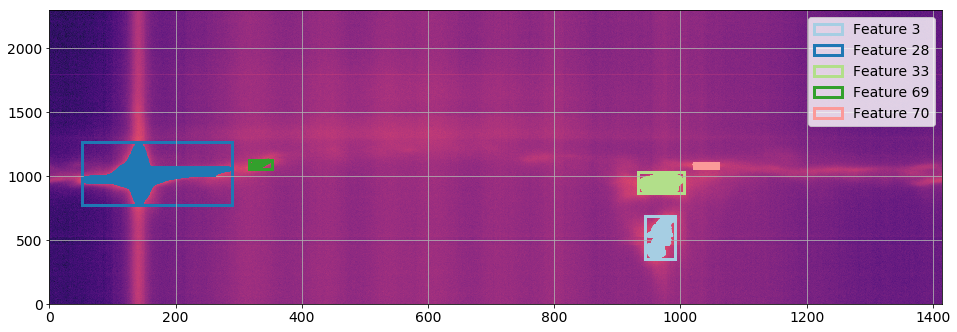

In [9]:

Xtimes, Yfreqs = np.meshgrid(sprg.times, sprg.freqs)

fmt = mdates.DateFormatter('%H:%M') #formatter to show just the hours and minutes

fig, ax = plt.subplots(figsize=(16,6))

cmap = cm.get_cmap('Paired')

#pcm = ax.pcolormesh(Xtimes, Yfreqs, sprg.pwr,
pcm = ax.pcolormesh(sprg.pwr,
                   #norm=colors.LogNorm(vmin=pwr.min(), vmax=pwr.max()), #uncomment for log normalized
                    norm=colors.PowerNorm(gamma=1./2.),
                    cmap='magma')

# plot each features' bounding box and its constituents; color code
for c,i in enumerate(props.FeatureId.tolist()):

    # get the bounding box, make a rectange and put it on the plot
    min_row, min_col, max_row, max_col = regprops[i-1].bbox
    rect = patches.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row,
                             linewidth=3,edgecolor=cmap(c),facecolor='none',label='Feature '+str(i))
    ax.add_patch(rect)
    
    #plot out the feature pixels with unique color for each feature
    coords = regprops[i-1].coords
    ax.plot(coords[:, 1], coords[:, 0], linewidth=2, color=cmap(c), fillstyle='none')
    
ax.grid()
fig.subplots_adjust(bottom=0.2)
ax.legend() # tack on the legend


## Retrieving Feature Contents
The figure above shows the features and their bounding boxes. Here we'll show two methods for retreiving just a feature's contents and not the contents of the enclosing bounding box.
### Method 1: Coordinate Method
The `regionprops` function mentioned earlier can also produce the (x,y) or (r,c) coordinates of each pixel in a feature.

In [10]:
# get the coordinates for feature # 70.
# note, feature #70 is at postion 69 in the region props list

feature70 = regprops[70-1]
coords70 = feature70.coords
coords.shape

(969, 2)

One row for each pixel. Note from above that the area of feature 70 is 969 pixels matching the number of rows in the coords matrix. Here are the first 10 coordinates:

In [11]:
coords[0:10,]

array([[1060, 1035],
       [1061, 1034],
       [1061, 1035],
       [1061, 1036],
       [1061, 1038],
       [1061, 1039],
       [1061, 1040],
       [1061, 1041],
       [1062, 1032],
       [1062, 1033]], dtype=int64)

The first column, `coords[ :,0]` is the row ordinate, which is actually the y-axis in the image. Similarly, the second column `coords[:,1]` is the column ordinate which is the x-axis in the image. Use `numpy` indexing of the image matrix to get the pixel values:

In [12]:
feature70_pwr = sprg.pwr[coords[:,0], coords[:,1]] 
len(feature70_pwr)

969

In [13]:
(feature70_pwr.mean(),feature70_pwr.max())

(0.76104819734778117, 0.77945215000000001)

Which match the mean and max power measures returned by the `regionprops` function for feature 70.

### Method 2: Matrix Multiply
If it is useful to have the original image with just a specific feature and all other pixels zeroed out, an element-wise matrix multiply will do the trick.

In [14]:
#isolate just the feature 23 pixels
feature28_img = sprg.pwr*(label_image==28)
feature28_img.shape

(2293, 1415)

In [15]:
np.count_nonzero(feature28_img)

24223

which matches the area returned by `regionprops` for feature 28.

Look at the mean and the max power:

In [16]:
nz = np.nonzero(feature28_img) # coords of the non-zero elements
feature28_pwr = sprg.pwr[nz[0], nz[1]] #power values in a 1-d array
(feature28_pwr.mean(), feature28_img.max())

(0.79942659634025515, 0.93416326999999999)

which match the values reported by `regionprops` for mean and max power respectively for feature 28.

In [17]:
props

,FeatureId,WeightedCentroid,Area,MeanPower,MaxPower
0,3,"(517.356966383, 967.69780298)",7932,0.759805,0.786659
1,28,"(1004.22546551, 148.282920683)",24223,0.799427,0.934163
2,33,"(941.124373217, 969.184765887)",7954,0.787234,0.859703
3,69,"(1089.5909084, 332.486655437)",1247,0.758213,0.771017
4,70,"(1079.29860984, 1039.35706653)",969,0.761048,0.779452


Look at a plot of just Feature 28:

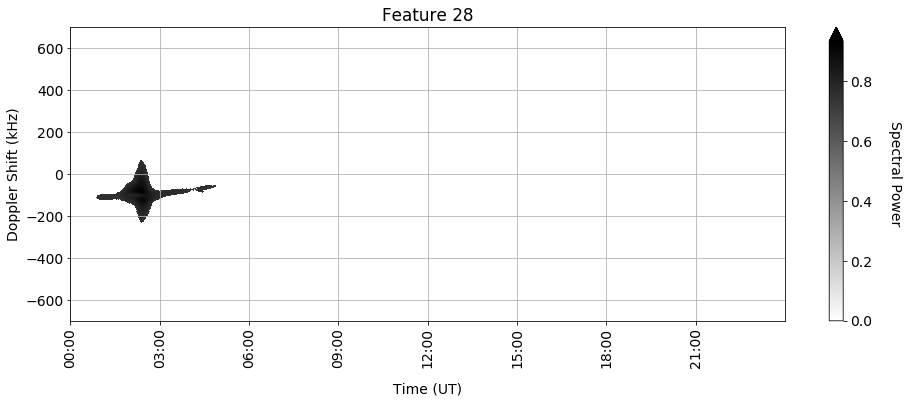

In [18]:
#make a time x frequency grid(mesh) for automatic axis labeling
Xtimes, Yfreqs = np.meshgrid(sprg.times, sprg.freqs)

fmt = mdates.DateFormatter('%H:%M') #formatter to show just the hours and minutes on the x-axis

fig, ax = plt.subplots(figsize=(16,6))

#color mesh plot
pcm = ax.pcolormesh(Xtimes, Yfreqs, feature28_img,
                   #norm=colors.LogNorm(vmin=pwr.min(), vmax=pwr.max()), #uncomment for log normalized
                    #norm=colors.PowerNorm(gamma=1./2.),
                    cmap='binary')

#reformat the x-axis tick labels only to show hh:mm
ax.set_xticklabels([fmt(t) for t in ax.get_xticks() ], rotation=90)
ax.set_xlabel('Time (UT)', labelpad=15)
ax.set_ylabel('Doppler Shift (kHz)')
ax.set_title('Feature 28')

ax.grid()
fig.subplots_adjust(bottom=0.2) # to make room for x-axis tick labels

#tack on and label the color bar on the right
cbar=fig.colorbar(pcm, ax=ax, extend='max')
cbar.set_label('Spectral Power', rotation=270, labelpad=30)
